# MRI Oximetry Calibration -- Bootstrap

This project aims at creating an MRI blood oximetry calibration model for patients with sickle cell disease. The data in this project comes from [this paper](https://pubmed.ncbi.nlm.nih.gov/33719133/). In summary, *in vivo* MRI T2 values of blood has a bilinear relationship with oxygenation (Y) and hematocrit (hct). In measuring T2 and hematocrit, we can use the calibration model to calculate blood oxygenation. 

Previous has demonstrated the calibration model for normal healthy blood (hemoglobin A). However, in sickle cell disease subjects, HbS blood has different magnetic properties and therefore requires a different calibration model. In the paper, previous work has performed *ex vivo* experiment, but there were only 16 data points. In order to derive the slope/intercept as well as the standard errors of the calibration model, bootstrapping is used.

Formulas for the calibration model can be found in the paper. In general, we measure the `A` and `B` parameters from MRI oximetry, measure hematocrit `hct` from blood-gas analysis, then calculate the intercepts and slopes for the linear relationship between (A, hct) and (B, hct).

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

Data used in this paper is directly taken from [this paper](https://pubmed.ncbi.nlm.nih.gov/33719133/).

In [3]:
A = [51.7, 64.7, 68, 46.2, 67.7, 72.7, 63.9, 54.4, 102.7, 78.5, 98.1, 84.2, 80.2, 76.2, 69.4, 70.1]
B = [7.8, 7.7, 6.4, 7.6, 7, 9.2, 6.9, 4.7, 6.8, 6.2, 7.2, 5.7, 5.4, 7, 5.8, 5.8]
hct = [0.196, 0.204, 0.254, 0.256, 0.258, 0.261, 0.273, 0.284, 0.306, 0.306, 0.356, 0.352, 0.334, 0.36, 0.24, 0.24]
data = pd.DataFrame(list(zip(A,B,hct)), columns=['A', 'B', 'hct'])
data

,A,B,hct
0,51.7,7.8,0.196
1,64.7,7.7,0.204
2,68.0,6.4,0.254
3,46.2,7.6,0.256
4,67.7,7.0,0.258
5,72.7,9.2,0.261
6,63.9,6.9,0.273
7,54.4,4.7,0.284
8,102.7,6.8,0.306
9,78.5,6.2,0.306


Library `statsmodels` is used to perform linear regression between A and hematocrit, and B and hematocrit.

In [4]:
def sm_ols(y, x, add_constant=True):
	if add_constant:
		x = sm.add_constant(x)
	lm = sm.OLS(y, x)
	res = lm.fit()
	intercept, slope = res.params
	intercept_se, slope_se a= res.HC0_se
	return {'intercept': intercept, 'slope': slope, 'intercept_se': intercept_se, 'slope_se': slope_se}, res

def sm_ols_predict(res, x, add_constant=True):
	if add_constant:
		x = sm.add_constant(x)
	pred = res.predict(x)
	return pred

def plot_ols(y, x, lm, scatter=True, color='grey', alpha=1):
	if scatter:
		plt.scatter(x,y)
	y_pred = lm['slope'] * x + lm['intercept']
	plt.plot(x, y_pred, color=color, alpha=alpha)

In [48]:
lm_A, res_A = sm_ols(data['A'], data['hct'])
lm_B, res_B = sm_ols(data['B'], data['hct'])

print('Intercept A: \t{0:.2f}'.format(res_A.params[0]))
print('Slope A: \t{0:.2f}'.format(res_A.params[1]))
print('Intercept B: \t{0:.2f}'.format(res_B.params[0]))
print('Slope B: \t{0:.2f}'.format(res_B.params[1]))

Intercept A: 	16.68
Slope A: 	196.85
Intercept B: 	8.56
Slope B: 	-6.64


Below, we show the linear regression without bootstrapping between (1) A and hematocrit, and (2) B and hematocrit. Similar to shown in the paper, the calibration model can be represented with the following formula:
$$A = 196.85 * Hct + 16.68$$
$$B = 8.56 * Hct - 6.64$$

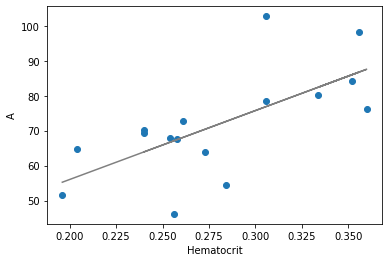

In [8]:
plot_ols(data['A'], data['hct'], lm_A)
plt.xlabel('Hematocrit')
plt.ylabel('A')
plt.show()

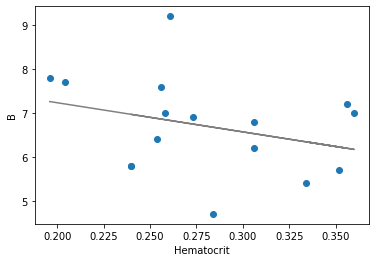

In [9]:
plot_ols(data['B'], data['hct'], lm_B)
plt.xlabel('Hematocrit')
plt.ylabel('B')
plt.show()

## Bootstrap
Previously, we have calculated the slopes and intercepts for the calibration models. However, we do not know the standard errors or confidence intervals for these slopes and intercepts. Therefore, in this project, we will bootstrap to calculate the standard error for the slopes and intercepts.

In [10]:
n_bootstrap = 1000 # how many bootstrap samples
n_samples = 10
bootstrap_A = pd.DataFrame(columns=['intercept', 'slope', 'intercept_se', 'slope_se'])
bootstrap_B = pd.DataFrame(columns=['intercept', 'slope', 'intercept_se', 'slope_se'])

for n in range(n_bootstrap):
	data_sample = data.sample(n=n_samples, replace=True)
	lm_A_bootstrap, _ = sm_ols(data_sample['A'], data_sample['hct'])
	bootstrap_A = bootstrap_A.append(lm_A_bootstrap, ignore_index=True)
	lm_B_bootstrap, _ = sm_ols(data_sample['B'], data_sample['hct'])
	bootstrap_B = bootstrap_B.append(lm_B_bootstrap, ignore_index=True)

In [36]:
print('A Intercept: \t{0:.2f} ± {1:.2f}'.format(bootstrap_A['intercept'].mean(), bootstrap_A['intercept'].std()))
print('A Slope: \t{0:.2f} ± {1:.2f}'.format(bootstrap_A['slope'].mean(), bootstrap_A['slope'].std()))

print('B Intercept: \t{0:.2f} ± {1:.2f}'.format(bootstrap_B['intercept'].mean(), bootstrap_B['intercept'].std()))
print('B Slope: \t{0:.2f} ± {1:.2f}'.format(bootstrap_B['slope'].mean(), bootstrap_B['slope'].std()))

A Intercept: 	15.66 ± 19.79
A Slope: 	200.10 ± 74.18
B Intercept: 	8.57 ± 1.92
B Slope: 	-6.74 ± 6.85


### A parameter

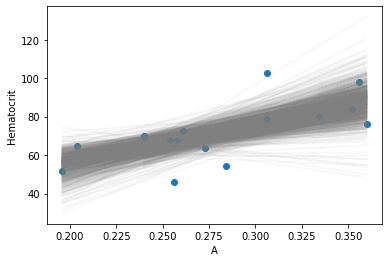

In [25]:
for index, row in bootstrap_A.iterrows():
	plot_ols(data['A'], data['hct'], row, scatter=False, alpha=0.05)
plt.scatter(data['hct'], data['A'])
plt.xlabel('A')
plt.ylabel('Hematocrit')
plt.show()

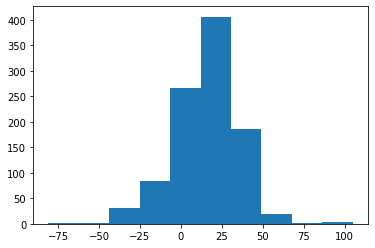

In [26]:
plt.hist(bootstrap_A['intercept'])
plt.show()

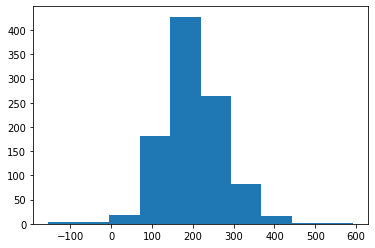

In [27]:
plt.hist(bootstrap_A['slope'])
plt.show()

### B parameter

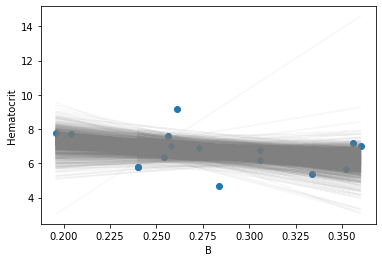

In [28]:
for index, row in bootstrap_B.iterrows():
	plot_ols(data['B'], data['hct'], row, scatter=False, alpha=0.05)
plt.scatter(data['hct'], data['B'])
plt.xlabel('B')
plt.ylabel('Hematocrit')
plt.show()

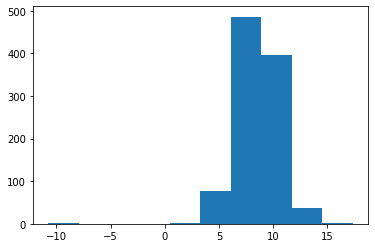

In [29]:
plt.hist(bootstrap_B['intercept'])
plt.show()

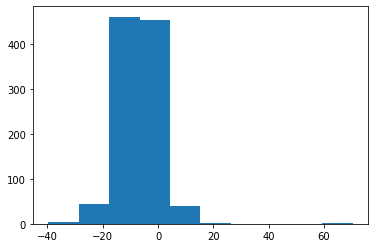

In [30]:
plt.hist(bootstrap_B['slope'])
plt.show()

# Bootstrap with Residuals (Non-parametric bootstrapping)
The weakness with normal bootstrapping is that outliers can be sampled multiple times and can influence the resulting parameters. Therefore, we will perform non-parametric bootstrapping (or bootstrap on the residuals). If we assume that residuals are normally distributed around 0, then randomly sampling the residuals and then adding them back into the predicted y values of our linear model can generate new predicted y. $ybootstrap = ypredicted + randomresiduals$
Afterward, we can fit $fit(x, ybootstrap)$ for each bootstrap sample to calculate the slopes and intercepts as well as their standard errors.

In [31]:
n_samples = len(data)
resid_A = res_A.resid
preds_A = sm_ols_predict(res_A, data['hct'])
resid_B = res_B.resid
preds_B = sm_ols_predict(res_B, data['hct'])

In [32]:
bootstrap_A_resid = pd.DataFrame(columns=['intercept', 'slope', 'intercept_se', 'slope_se'])
bootstrap_B_resid = pd.DataFrame(columns=['intercept', 'slope', 'intercept_se', 'slope_se'])
for n in range(n_bootstrap):
	resid_A_bootstrap = np.random.choice(resid_A, n_samples, replace=True)
	y_resid_A = [p+r for p, r in zip(preds_A, resid_A_bootstrap)]
	lm_A_bootstrap_resid, _ = sm_ols(y_resid_A, data['hct'])
	bootstrap_A_resid = bootstrap_A_resid.append(lm_A_bootstrap_resid, ignore_index=True)

	resid_B_bootstrap = np.random.choice(resid_B, n_samples, replace=True)
	y_resid_B = [p+r for p, r in zip(preds_B, resid_B_bootstrap)]
	lm_B_bootstrap_resid, _ = sm_ols(y_resid_B, data['hct'])
	bootstrap_B_resid = bootstrap_B_resid.append(lm_B_bootstrap_resid, ignore_index=True)

In [35]:
print('A Intercept: \t{0:.2f} ± {1:.2f}'.format(bootstrap_A_resid['intercept'].mean(), bootstrap_A_resid['intercept'].std()))
print('A Slope: \t{0:.2f} ± {1:.2f}'.format(bootstrap_A_resid['slope'].mean(), bootstrap_A_resid['slope'].std()))

print('B Intercept: \t{0:.2f} ± {1:.2f}'.format(bootstrap_B_resid['intercept'].mean(), bootstrap_B_resid['intercept'].std()))
print('B Slope: \t{0:.2f} ± {1:.2f}'.format(bootstrap_B_resid['slope'].mean(), bootstrap_B_resid['slope'].std()))

A Intercept: 	16.66 ± 15.57
A Slope: 	197.01 ± 54.68
B Intercept: 	8.41 ± 1.51
B Slope: 	-6.09 ± 5.32


### A parameter

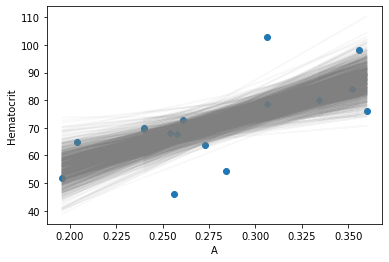

In [38]:
for index, row in bootstrap_A_resid.iterrows():	
	plot_ols(y_resid_A, data['hct'], row, scatter=False, alpha=0.05)
plt.scatter(data['hct'], data['A'])
plt.xlabel('A')
plt.ylabel('Hematocrit')
plt.show()

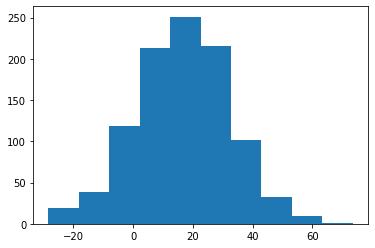

In [39]:
plt.hist(bootstrap_A_resid['intercept'])
plt.show()

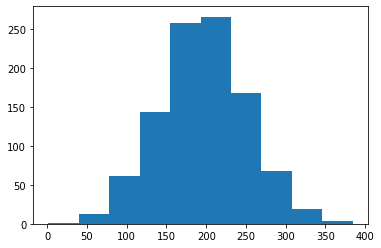

In [40]:
plt.hist(bootstrap_A_resid['slope'])
plt.show()

### B parameter

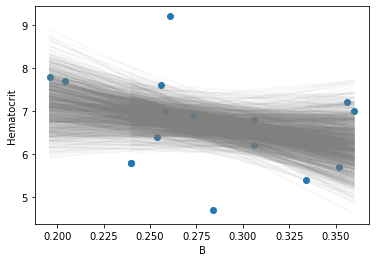

In [41]:
for index, row in bootstrap_B_resid.iterrows():	
	plot_ols(y_resid_B, data['hct'], row, scatter=False, alpha=0.05)
plt.scatter(data['hct'], data['B'])
plt.xlabel('B')
plt.ylabel('Hematocrit')
plt.show()

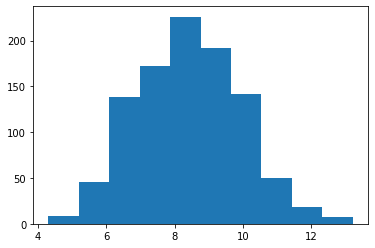

In [42]:
plt.hist(bootstrap_B_resid['intercept'])
plt.show()

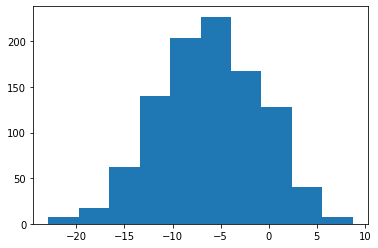

In [43]:
plt.hist(bootstrap_B_resid['slope'])
plt.show()

## Conclusion
In summary, here are out calibration models generated (1) without bootstrapping, (2) with regular bootstrapping, and (3) with non-parametric bootstrapping. The standard errors are smaller for non-parametric bootstrapping, demonstrating that certain outliers are being resampled multiple times during the regular bootstrapping process and influences the resulting parameters.

### (1) Without bootstrapping:
$$A = (196.85) * Hct + (16.68)$$
$$B = (8.56) * Hct    - (6.64)  $$

### (2) With regular bootstrapping:
$$A = (200.10 ± 74.18) * Hct + (15.66 ± 19.79)$$
$$B = (8.57 ± 1.92) * Hct    - (6.74 ± 6.85) $$

### (3) With non-parametric bootstrapping:
$$A = (197.01 ± 54.68) * Hct + (16.66 ± 15.57)$$
$$B = (8.41 ± 1.51) * Hct    - (6.09 ± 5.32) $$